> ### EEE4423: Deep Learning Lab

# LAB \#3: CNN: VGG Net and ResNet

<h4><div style="text-align: right"> Due date: March 25, 2022.  </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab03.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[Insert your ID HERE] [Insert your name HERE]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2022-03-22 11:03:21.127117


## 1. VGGNet with PyTorch

### Implementing VGGNet

> 1. **Dataset**
>> - Images from the first three categories in CIFAR-10. (Due to the computational constraints.)  <br>
     Three categories : plane, car, bird  /  The number of training images : 15,000   /  The number of test images : 3,000
>> - Augmented with flipping and random cropping.
>
> 2. **Network architecture**
>> - Type-D configuration in the paper (+ 3-way classifier after convolutional layers).
>> - ReLU activation.
>> - No dropout for simplicity.
>> - We will apply **batch-normalization** after every convolution which is not used in the paper (otherwise, hard to optimize).
>>
>> <table><tr>
>> <td> <img src="http://drive.google.com/uc?export=view&id=1jn7ICUJAcTF3WQ1XuUffOdmprgj4u1c3" alt="no_image" style="width: 550px;"/> </td>
>> <td> <img src="http://drive.google.com/uc?export=view&id=1Rz0iWW6VoLD_XGdRa3ofYyhCTTb6kR_k" alt="no_image" style="width: 250px;"/> </td>
>> </tr></table>
>>
>> <font size="0.5"> Figure from <br>
>> [1] https://www.quora.com/What-is-the-VGG-neural-network </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
     Note that `nn.CrossEntroyLoss` takes logits before softmax as network outputs and scalar index (not one-hot vector) as ground-truths.<br>
     See https://pytorch.org/docs/stable/nn.html#crossentropyloss for details.
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 20 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
> 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets 
import torchvision
import time
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='../dataset/lab03', 
                            train=True, 
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='../dataset/lab03', 
                           train=False, 
                           transform=transform_test)

STEP 1: LOADING DATASET


1.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

6.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

11.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

18.4%IOPub m

In [ ]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))
        
reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [ ]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [ ]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset, 
                                          batch_size=100, 
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

tensor([0, 2, 2, 0])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3])
tensor([ 5.1776, -3.4805, -1.8904], device='cuda:0', grad_fn=<SliceBackward0>)


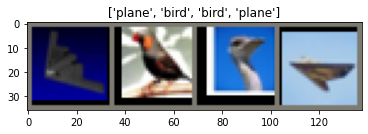

In [ ]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=4, 
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))
# iter과 next 학습

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(classes)
print(inputs.size())
outputs = model(inputs.to(device))
print(outputs.size())
print(outputs[0,:])
imshow(out, title=[class_names[x] for x in classes])

### 1.1 Write code (VGG 16) [3 points]

In [ ]:
print('STEP 3: CREATE MODEL CLASS (VGG16)')

class VGG(nn.Module) : 
    def __init__(self) :
        super(VGG,self).__init__()
        self.conv = nn.Sequential(
        # 3 32 32
        # Convolution 1,2 -> conv3-64 , Max pool
        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정
        nn.Conv2d(in_channels=3, out_channels = 64, kernel_size=3, padding=1,bias=False),nn.BatchNorm2d(64),nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels = 64, kernel_size= 3, padding=1,bias=False),nn.BatchNorm2d(64),nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
                    
        # 64 16 16
        # Convolution 3,4 -> conv3-128 , Max pool
        nn.Conv2d(in_channels=64, out_channels = 128, kernel_size=3, padding=1,bias=False),nn.BatchNorm2d(128), nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels = 128, kernel_size= 3, padding=1,bias=False),nn.BatchNorm2d(128), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        #128 8 8
        # Convolution 5,6,7 -> conv3-256, Max pool
        nn.Conv2d(in_channels=128, out_channels = 256, kernel_size=3, padding=1,bias=False),nn.BatchNorm2d(256), nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels = 256, kernel_size= 3, padding=1,bias=False),nn.BatchNorm2d(256), nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels = 256, kernel_size= 3, padding=1,bias=False),nn.BatchNorm2d(256), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
            
        # 256 4 4 
        # Convolution 8,9,10 -> conv3-512, Max pool
        nn.Conv2d(in_channels=256, out_channels = 512, kernel_size=3, padding=1,bias=False),nn.BatchNorm2d(512), nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels = 512, kernel_size= 3, padding=1,bias=False),nn.BatchNorm2d(512), nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels = 512, kernel_size= 3, padding=1,bias=False),nn.BatchNorm2d(512), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        # 512 2 2
        # Convolution 11,12,13 -> conv3-512, Max pool
        nn.Conv2d(in_channels=512, out_channels = 512, kernel_size=3, padding=1,bias=False),nn.BatchNorm2d(512), nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels = 512, kernel_size= 3, padding=1,bias=False),nn.BatchNorm2d(512), nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels = 512, kernel_size= 3, padding=1,bias=False),nn.BatchNorm2d(512), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),    
       #512 1 1
        )
        
        self.classifier = nn.Linear(in_features=512*1*1, out_features=3) # 마지막이니깐 ReLU()는 필요없다.
        
#         self.classifier = nn.Sequential(
#             nn.Linear(512 * 1 * 1, 4096),
#             nn.ReLU(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(),
#             nn.Linear(4096, 3)
#         )
    def forward(self,x):
        x = self.conv(x)
        x= x.view(x.shape[0],-1) # x.shape[0] =batch size
        # shape torch.Size([1, 2, 200, 100]), i.e [batch=1, ch=2, height=200, width=100 ]
        #x= x.view(-1,512*1*1)
        x= self.classifier(x)
        return x

STEP 3: CREATE MODEL CLASS (VGG16)


In [ ]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model = VGG()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(model.to(device))
print(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  14720451
VGG(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, 

In [ ]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


In [ ]:
device

device(type='cuda', index=0)

### 1.2 Train the VGG 16 model and print test accuracy for every epochs [2 points]

In [ ]:
import time

print('STEP 7: TRAIN THE MODEL')
num_epochs = 20

for epoch in range(num_epochs) : 
    start = time.time()
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

    # Calculate Accuracy
    model.eval()
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in test_loader:
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total

    end = time.time()
    # Print Loss
    print('Epochs: {}. Loss: {:.2f}. Accuracy: {:.2f}. Elapsed time: {:.2f}sec'.format(epoch, loss.item(), accuracy, end - start))

STEP 7: TRAIN THE MODEL
Epochs: 0. Loss: 0.51. Accuracy: 80.60. Elapsed time: 12.86sec
Epochs: 1. Loss: 0.33. Accuracy: 85.90. Elapsed time: 4.58sec
Epochs: 2. Loss: 0.41. Accuracy: 88.60. Elapsed time: 4.61sec
Epochs: 3. Loss: 0.40. Accuracy: 90.30. Elapsed time: 4.58sec
Epochs: 4. Loss: 0.08. Accuracy: 91.00. Elapsed time: 4.66sec
Epochs: 5. Loss: 0.36. Accuracy: 89.53. Elapsed time: 4.64sec
Epochs: 6. Loss: 0.17. Accuracy: 91.43. Elapsed time: 4.66sec
Epochs: 7. Loss: 0.04. Accuracy: 92.30. Elapsed time: 4.64sec
Epochs: 8. Loss: 0.24. Accuracy: 91.53. Elapsed time: 4.67sec
Epochs: 9. Loss: 0.20. Accuracy: 90.20. Elapsed time: 4.62sec
Epochs: 10. Loss: 0.03. Accuracy: 92.07. Elapsed time: 4.59sec
Epochs: 11. Loss: 0.31. Accuracy: 91.87. Elapsed time: 4.59sec
Epochs: 12. Loss: 0.02. Accuracy: 93.20. Elapsed time: 4.65sec
Epochs: 13. Loss: 0.06. Accuracy: 91.27. Elapsed time: 4.76sec
Epochs: 14. Loss: 0.01. Accuracy: 93.70. Elapsed time: 4.78sec
Epochs: 15. Loss: 0.00. Accuracy: 93.33.

 "예상했던 점, 예상과 달랐던 점, 또는 개선할 점"과 같은 요약 내용을 기술해주시면 되겠습니다. (예시) ~ 해서 ~ 결과를 얻었고, 이는 ~ 으로 인한 것으로 생각된다."
 
 FC layer가 변형된 VGG 16을 디자인해서 대략 93%의 정확도를 가지는 결과를 얻었고 이는  VGG net의 특징인 Convoluational layer depth를 높이면 정확도가 높아진다는 논문의 결과와 일치한다.
 예상과 달랐던 점은 전처리 과정이 없이도 90%에 달하는 정확도를 간단한 이미지이지만 RGB 이미지에서 달성했다는 것이다.
 좀 더 class가 많고 resolution이 높은 데이터에서 이같은 결과가 생기는지 궁금하고 만약 그렇담 당장 사용할 수 있는 모델이라는 생각이 들었다.
 
 
 개선할 점 : 학습 데이터에 맞는 전처리 과정이 추가된다면 더 놓은 정확도를 얻을 것이다. epochs 당 실행시간이 길기 때문에 모델의 무게감이 있어 실시간 처리에는 적합하지 않을 것이다. 

## 2. ResNet with PyTorch

### Implementing ResNet

> 1. **Dataset**
>> - The same dataset used for VGGNet
>
> 2. **Network architecture**
>> - 50-layer ResNet with **bottleneck blocks**. <br>
     Note. The initial convolution layer (i.e., conv1) is different from the one in the paper &<br>
     the initial max-pooling layer is removed (because the size of CIFAR-10 images is too small).
>> - ReLU activation.
>> - Strided convolution for down-sampling instead of max-pooling layer. <br>
     Note. Once down-sampled, a $1\times1$ convolution/stride 2 is applied to residual for expanding the channel of the residual.
>> - No dropout for simplicity.
>> - Batch-normalization after every convolution.
>>
>>
>> <table><tr>
>> <td> <img src="http://drive.google.com/uc?export=view&id=1l3rC40WnBXZBagFIuME48SPvcqVY-56Y" alt="no_image" style="width: 500px;"/> </td>
>> <td> <img src="http://drive.google.com/uc?export=view&id=1r92UcNqn6ZT5pOk3emEijjTKlWdAYvCk" alt="no_image" style="width: 300px;"/> </td>
>> </tr></table>
>>
>> <img src="http://drive.google.com/uc?export=view&id=1n0NYyWWbDBd9PHjNEs7AHpOhMci5q6qk" alt="no_image" style="width: 870px;"/>
>>
>> <font size="0.5"> Figures from <br> 
>> [1] https://www.codeproject.com/Articles/1248963/Deep-Learning-using-Python-plus-Keras-Chapter-Re  <br> 
>> [2] Rezende et al., *Signal Processing: Image Communication*, 2018. </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 15 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
> 

### 2.1 Implement ResNet50 and train it with the CIFAR 10 dataset [4 points] 

In [7]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='../dataset/lab03', 
                            train=True, 
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='../dataset/lab03', 
                           train=False, 
                           transform=transform_test)

STEP 1: LOADING DATASET


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../dataset/lab03/cifar-10-python.tar.gz to ../dataset/lab03


In [8]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))
        
reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [9]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [10]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset, 
                                          batch_size=100, 
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


In [11]:
print('STEP 3: CREATE MODEL CLASS (ResNet-50)')
#############
# CODE HERE #
#############

import torch
import torch.nn as nn
from torch import Tensor

class Bottleneck(nn.Module):
    def __init__(self, in_channels,hidden_channels, out_channels, down= False, stride=1):
        super().__init__()
        self.relu = nn.ReLU()
        if down == False :
            self.bottleneck = nn.Sequential(
                ## ex in_channels = 64, hidden_channels=64, out_chaannels =64
                ##256x32x32 down이 아닐때: 
                nn.Conv2d(in_channels, hidden_channels, kernel_size=1, stride=1, bias=False),  ## 여기서 stride는 1이 될 수도 2가 될수도 있다.(down 여부에 따라 결정 혹은 stride 값으로 결정)
                nn.BatchNorm2d(hidden_channels), nn.ReLU(),
                ## 256x32x32
                nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),  ## 계산
                nn.BatchNorm2d(hidden_channels), nn.ReLU(),
                ## 256x32x32
                nn.Conv2d(hidden_channels, out_channels, kernel_size=1, stride=1, bias=False),  ## 원상 복구
                nn.BatchNorm2d(out_channels)
                ## 256x32x32
            )
            self.shortcut = nn.Sequential(
            )
        elif down == True :
            self.bottleneck = nn.Sequential(
                ## ex in_channels = 64, hidden_channels=64, out_chaannels =64
                ##256x32x32 down일때: 
                nn.Conv2d(in_channels, hidden_channels, kernel_size=1, stride=stride, bias=False),  ## 여기서 stride는 1이 될 수도 2가 될수도 있다.(down 여부에 따라 결정 혹은 stride 값으로 결정)
                nn.BatchNorm2d(hidden_channels), nn.ReLU(),
                ## 128x16x16
                nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),  ## 계산
                nn.BatchNorm2d(hidden_channels), nn.ReLU(),
                ## 128x16x16
                nn.Conv2d(hidden_channels, out_channels, kernel_size=1, stride=1, bias=False),  ## 원상 복구
                nn.BatchNorm2d(out_channels)
                ## 512x16x16
            )
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x: Tensor) -> Tensor:
        x = self.bottleneck(x) + self.shortcut(x)
        x = self.relu(x)
        return x

class ResNet_50(nn.Module):
    def __init__(self,num_classes: int = 3) :
        super().__init__()
        # 3x32x32
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),nn.BatchNorm2d(64),nn.ReLU(),
            #cfg[0]=3 64x32x32
            Bottleneck(64,64,256,down=True,stride=1),
            Bottleneck(256,64,256,down=False,stride=1),
            Bottleneck(256,64,256,down=False,stride=1),
            #cfg[1]=4 256x32x32
            Bottleneck(256,128,512,down=True,stride=2),
            Bottleneck(512,128,512,down=False,stride=1),
            Bottleneck(512,128,512,down=False,stride=1),
            Bottleneck(512,128,512,down=False,stride=1),
            #cfg[2]=6 512x16x16
            Bottleneck(512,256,1024,down=True,stride=2),
            Bottleneck(1024,256,1024,down=False,stride=1),
            Bottleneck(1024,256,1024,down=False,stride=1),
            Bottleneck(1024,256,1024,down=False,stride=1),
            Bottleneck(1024,256,1024,down=False,stride=1),
            Bottleneck(1024,256,1024,down=False,stride=1),
            #cfg[3]=3 1024x8x8
            Bottleneck(1024,512,2048,down=True,stride=2),
            Bottleneck(2048,512,2048,down=False,stride=1),
            Bottleneck(2048,512,2048,down=False,stride=1)
            #2048x4x4
        )
        self.avgpool = nn.AvgPool2d(4,1)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        ## 3 x32 x 32
        x = self.conv(x)
        ## 2048x4x4
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

STEP 3: CREATE MODEL CLASS (ResNet-50)


In [12]:
print('STEP 4: INSTANTIATE MODEL CLASS')
#############
# CODE HERE #
#############

model = ResNet_50()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(model.to(device))
print(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  23506499
ResNet_50(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Bottleneck(
      (relu): ReLU()
      (bottleneck): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kern

### 2.2 Print test accuracy for every epochs. [1 points]

In [13]:
print('STEP 5: INSTANTIATE LOSS CLASS')
#############
# CODE HERE #
#############
criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')
#############
# CODE HERE #
#############
learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

print('STEP 7: TRAIN THE MODEL')
#############
# CODE HERE #
#############
num_epochs = 15

for epoch in range(num_epochs) : 
    start = time.time()
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

    # Calculate Accuracy
    model.eval()
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in test_loader:
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total

    end = time.time()
    # Print Loss
    print('Epochs: {}. Loss: {:.2f}. Accuracy: {:.2f}. Elapsed time: {:.2f}sec'.format(epoch, loss.item(), accuracy, end - start))

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS
STEP 7: TRAIN THE MODEL
Epochs: 0. Loss: 0.67. Accuracy: 74.20. Elapsed time: 109.87sec
Epochs: 1. Loss: 0.71. Accuracy: 69.93. Elapsed time: 109.84sec
Epochs: 2. Loss: 0.65. Accuracy: 80.73. Elapsed time: 109.65sec
Epochs: 3. Loss: 0.48. Accuracy: 82.77. Elapsed time: 109.84sec
Epochs: 4. Loss: 0.24. Accuracy: 84.53. Elapsed time: 109.90sec
Epochs: 5. Loss: 0.74. Accuracy: 86.27. Elapsed time: 110.14sec
Epochs: 6. Loss: 0.35. Accuracy: 86.57. Elapsed time: 110.70sec
Epochs: 7. Loss: 0.06. Accuracy: 85.03. Elapsed time: 111.04sec
Epochs: 8. Loss: 0.18. Accuracy: 86.37. Elapsed time: 110.98sec
Epochs: 9. Loss: 0.31. Accuracy: 87.03. Elapsed time: 110.94sec
Epochs: 10. Loss: 0.12. Accuracy: 84.40. Elapsed time: 110.86sec
Epochs: 11. Loss: 0.23. Accuracy: 86.30. Elapsed time: 110.96sec
Epochs: 12. Loss: 0.24. Accuracy: 87.40. Elapsed time: 110.90sec
Epochs: 13. Loss: 0.07. Accuracy: 86.33. Elapsed time: 111.02sec
Epochs: 1

 예상했던 점 : 분명 VGG보다 ResNet이 논문 상으로는 더 빨리 계산되어야 하고 더 높은 정확도를 보여야한다.

예상과 달랐던 점 : ResNet이 더 많은 시간이 걸렸다 그 이유로는 모든 layer에 batch normalization을 적용하고 있기 때문인데 이 때문에 parameter 수가 23506499로 VGG16의 14720451보다 더 많아졌기 때문에 더 많은 속도가 걸린다.

계선할 점 : initialzation을 잘하면 정확도가 더 높을 수 있다는데 따로 설정하지 않을 시 pytorch 는 default 로 uniform distribution 에서 randomly initialize 해준다고 한다. 정확도를 더 높이기 위해서는 input사진의 밝기등을 일정하게 해주면 더 좋은 결과가 나올수도 있을 것 같다. 또한 CIVAR 10 데이터 셋은 resoluation이 좋지 않은데 이것을 높은 해상도로 변환해주는 알고리즘을 사용하면 결과가 좀더 좋을 것 같다. 또한 ResNet의 경우에서만 한정한다면 여기서는 BatchNormalization을 너무 과도하게 사용했기 때문에 매우 오랜 시간이 걸리는데 이를 적절히 조절하면 좋을 것 같다. 

참고로 하자면 VGG16의 경우에는 GeForce RTX 3060Ti로 실시하였고 
ResNet의 경우 GPU 용량 초과로 colab에서 진행하였다. 
ResNet의 경우 1epoch까지는 돌아갔는데 이 때 걸린 시간은 27s였다.